In [1]:
import pandas
import seaborn

from matplotlib import pyplot

import swasputils

In [2]:
all_classifications = swasputils.ZooniverseClassifications()

In [3]:
filtering_classifications = all_classifications.get_workflow(swasputils.JUNK_WORKFLOW)
main_classifications = all_classifications.get_workflow(swasputils.MAIN_WORKFLOW)

In [4]:
filtering_users = filtering_classifications.df[filtering_classifications.df['user_id'].notna()]['user_name'].value_counts()
main_users = main_classifications.df[main_classifications.df['user_id'].notna()]['user_name'].value_counts()

In [5]:
user_counts = pandas.DataFrame({
    'Main Workflow': main_users,
    'Filtering Workflow': filtering_users
}).fillna(0)
user_counts['Workflows'] = user_counts.apply(
    lambda row: 'Both' if row['Main Workflow'] > 0 and row['Filtering Workflow'] > 0 else 'Main' if row['Main Workflow'] > 0  else 'Filtering',
    axis='columns',
)

<AxesSubplot:>

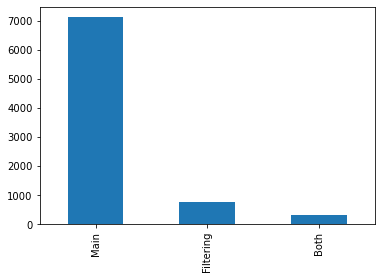

In [6]:
user_counts['Workflows'].value_counts().plot.bar()

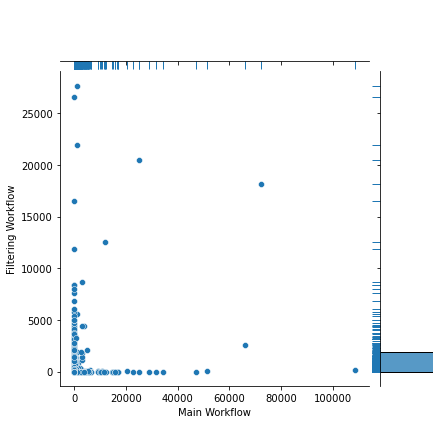

In [7]:
seaborn.jointplot(
    data=user_counts,
    x='Main Workflow', 
    y='Filtering Workflow',
).plot_marginals(seaborn.rugplot, height=-.15, clip_on=False)

## Agreement Between Classifications per User

In [8]:
users_both = user_counts[user_counts['Workflows'] == 'Both']
len(users_both)

332

In [9]:
users_both_classifications = swasputils.ZooniverseClassifications(
    df=all_classifications.df[
        all_classifications.df['user_name'].isin(users_both.index)
        & all_classifications.df['workflow_id'].isin((swasputils.MAIN_WORKFLOW, swasputils.JUNK_WORKFLOW))
    ],
)

In [10]:
users_both_classifications.decode_annotations()

In [11]:
user_both_per_subject = users_both_classifications.df.drop_duplicates([
    'user_id',
    'subject_ids',
    'workflow_id',
]).pivot(
    index=['user_name', 'subject_ids'],
    columns='workflow_id',
    values='annotation_T0'
).dropna()
user_both_per_subject[swasputils.MAIN_WORKFLOW] = user_both_per_subject.apply(
    lambda row: 'Junk' if row[swasputils.MAIN_WORKFLOW] == 'Junk' else 'Real',
    axis='columns',
)
user_both_per_subject

workflow_id                 7534  17313
user_name       subject_ids            
AJNORTON        22109915     Junk  Junk
Adriana.Dominik 22515973     Junk  Junk
                22994184     Junk  Junk
                24452755     Junk  Real
                25052708     Real  Real
...                           ...   ...
viligoaround    25003233     Junk  Junk
                25047405     Junk  Junk
                25053511     Real  Real
zephcat         22993765     Junk  Junk
                24367460     Real  Real

[6443 rows x 2 columns]

<AxesSubplot:title={'center':'Per-User Class in Main Workflow vs Filtering Workflow'}, xlabel='17313', ylabel='7534'>

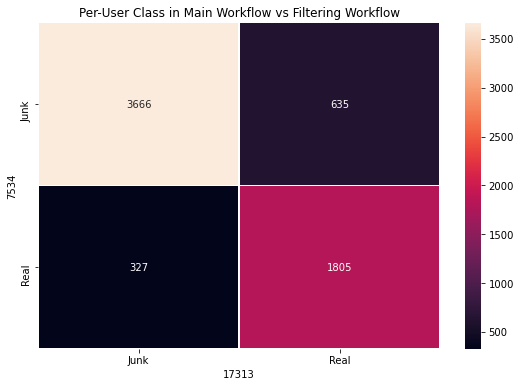

In [12]:
user_both_per_subject_comparison = user_both_per_subject.reset_index().pivot_table(
    index=swasputils.MAIN_WORKFLOW,
    columns=swasputils.JUNK_WORKFLOW,
    values='subject_ids',
    aggfunc=lambda x: len(x.unique()),
)
f, ax = pyplot.subplots(figsize=(9, 6))
pyplot.title('Per-User Class in Main Workflow vs Filtering Workflow')
seaborn.heatmap(user_both_per_subject_comparison, annot=True, fmt=".0f", linewidths=.5, ax=ax)

## Mobile App vs Browser

<ipython-input-13-174e3164850d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtering_classifications.df['Platform'] = filtering_classifications.df.apply(


<AxesSubplot:>

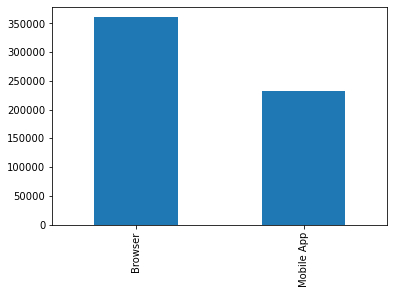

In [13]:
filtering_classifications.df['Platform'] = filtering_classifications.df.apply(
    lambda row: 'Mobile App' if 'Mobile App' in row['metadata'] else 'Browser',
    axis='columns',
)
filtering_classifications.df['Platform'].value_counts().plot.bar()

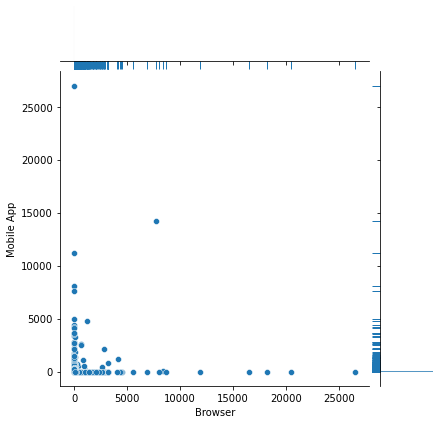

In [14]:
user_app_counts = filtering_classifications.df.pivot_table(
    index='user_name',
    columns='Platform',
    values='subject_ids',
    aggfunc=lambda x: len(x.unique()),
).fillna(0)
seaborn.jointplot(
    data=user_app_counts,
    x='Browser', 
    y='Mobile App',
).plot_marginals(seaborn.rugplot, height=-.15, clip_on=False)